# Try to make ice shelf mask??

In [1]:
import xesmf
import xarray as xr
import os
import cmocean as cm
import cartopy.crs as ccrs
import cosima_cookbook as cc
from dask.distributed import Client
import dask.array as da
import numpy as np
from osgeo import gdal
import matplotlib.pyplot as plt

from pyproj import Transformer
from pyproj import CRS
ps_to_ll = Transformer.from_crs( "EPSG:3031","EPSG:4326", always_xy=True) 
#

In [4]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 14,Total memory: 63.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38353,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 14
Started: Just now,Total memory: 63.00 GiB
Comm: tcp://127.0.0.1:39661,Total threads: 2
Dashboard: /proxy/32835/status,Memory: 9.00 GiB
Nanny: tcp://127.0.0.1:36175,


2025-05-28 21:29:43,137 - distributed.nanny - WARNING - Restarting worker
2025-05-28 21:29:43,153 - distributed.nanny - WARNING - Restarting worker
2025-05-28 21:29:43,156 - distributed.nanny - WARNING - Restarting worker
2025-05-28 21:29:43,164 - distributed.nanny - WARNING - Restarting worker
2025-05-28 21:29:43,170 - distributed.nanny - WARNING - Restarting worker
2025-05-28 21:29:43,177 - distributed.nanny - WARNING - Restarting worker
2025-05-28 21:29:43,183 - distributed.nanny - WARNING - Restarting worker


I have saved the regridded Charrassin data of several variables on the model grid using notebook `Generate-Charrassin-bathy.ipynb`

```
/g/data/x77/cy8964/mom6/input/input-8km/ice_thickness_Charrassin_regridded.nc
/g/data/x77/cy8964/mom6/input/input-8km/surface_Charrassin_regridded.nc
/g/data/x77/cy8964/mom6/input/input-8km/topog_Charrassin_regridded.nc
/g/data/x77/cy8964/mom6/input/input-8km/WATER_HEIGHT_Charrassin_regridded.nc


In [2]:
topog = xr.open_dataset('/g/data/x77/cy8964/mom6/input/input-8km/topog_Charrassin_regridded.nc')
ice_thick = xr.open_dataset('/g/data/x77/cy8964/mom6/input/input-8km/ice_thickness_Charrassin_regridded.nc')
surface = xr.open_dataset('/g/data/x77/cy8964/mom6/input/input-8km/surface_Charrassin_regridded.nc')
water_height = xr.open_dataset('/g/data/x77/cy8964/mom6/input/input-8km/WATER_HEIGHT_Charrassin_regridded.nc')

Assume that ice density is 918 and ocean is 1035

Assuming, hydrostatic balance, then the bottom depth of ice shelf cavity $\eta_{ib}$ is `ice_thick*918/1035` and top of ice $\eta_{ti}$ is `(ice_thick*(1-918/1035))`

If bottom depth is deeper than topography ($\eta_b$), assume it is grounded.

Ocean thickness (water height) will be bottom depth $H$ - $\eta_{ib}$

In [19]:
rho_ice = 916.7 #918
rho_ocean = 1028 #1035

eta_ib = ice_thick.thick*rho_ice/rho_ocean 
eta_it = ice_thick.thick*(1-rho_ice/rho_ocean)
eta_b = topog.depth

(0.0, 1200.0)

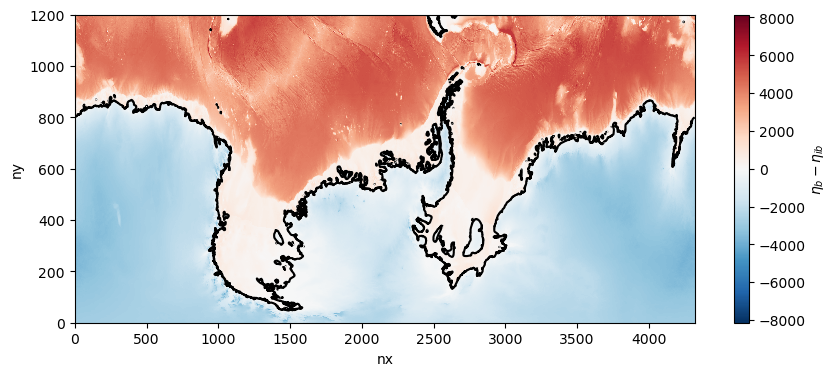

In [20]:
fig = plt.figure(figsize = (10,4))
(eta_b - eta_ib).plot(cbar_kwargs = {'label':r'$\eta_b - \eta_{ib}$'})
(eta_b - eta_ib).plot.contour(levels = [0], colors = 'k')

plt.ylim(0,1200)

(0.0, 1200.0)

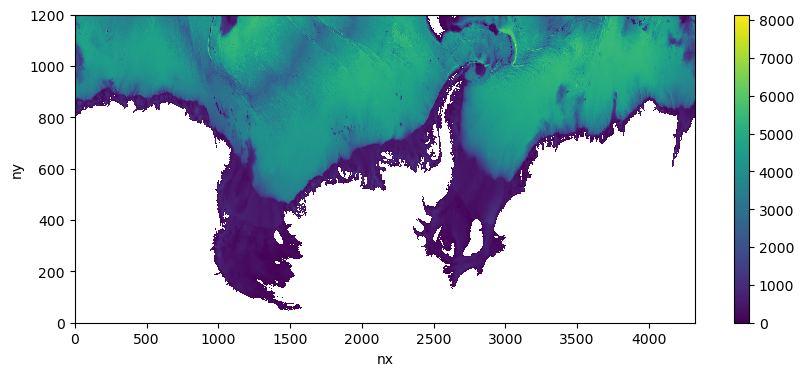

In [21]:
ocean_column_assump = (eta_b - eta_ib).where((eta_b - eta_ib)>0)

fig = plt.figure(figsize = (10,4))
ocean_column_assump.plot()
plt.ylim(0,1200)

Text(0.5, 1.0, 'Ocean column thickness \n difference between hydrostatic assump method and data')

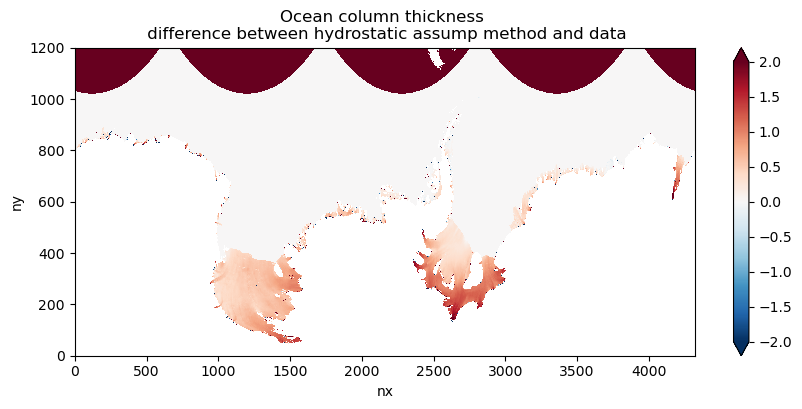

In [24]:
fig = plt.figure(figsize = (10,4))
(ocean_column_assump - water_height.elevation).plot(vmax = 2, vmin = -2, cmap = 'RdBu_r')
plt.ylim(0,1200)
plt.title('Ocean column thickness \n difference between hydrostatic assump method and data')

Text(0.5, 1.0, 'Surface ice elevation \n difference between hydrostatic assump method and data for ocean regions')

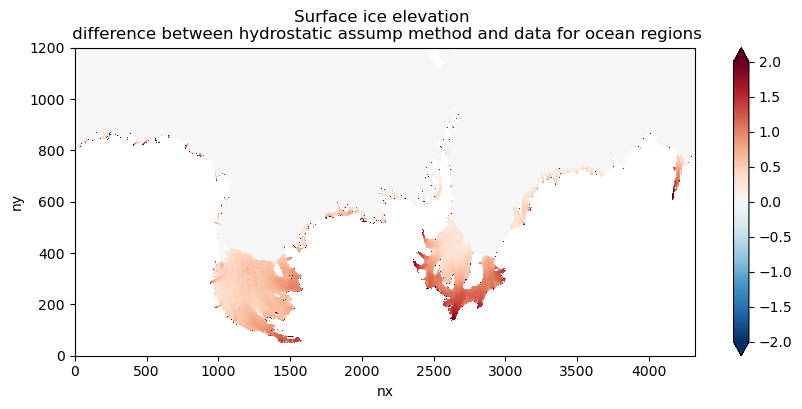

In [27]:
fig = plt.figure(figsize = (10,4))
(eta_it - surface.elevation).where(ocean_column_assump>0).plot( cmap = 'RdBu_r', vmax = 2, vmin = -2)
plt.ylim(0,1200)
plt.title('Surface ice elevation \n difference between hydrostatic assump method and data for ocean regions')

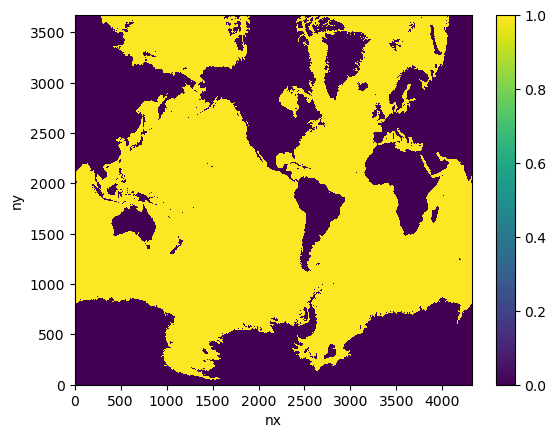

In [29]:
draft_ocean_mask = xr.where(ocean_column_assump>0,1,0)
draft_ocean_mask.plot()

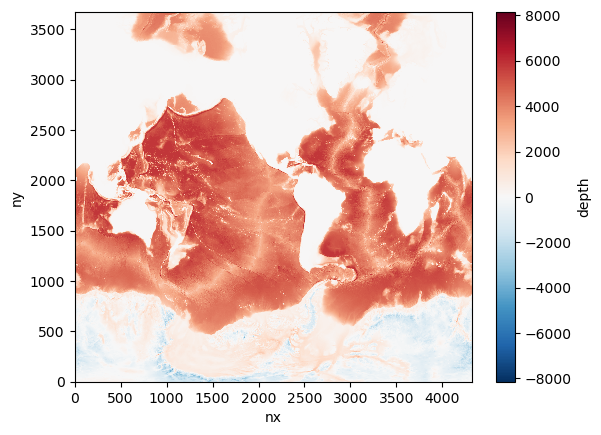

In [35]:
topog.depth.plot()

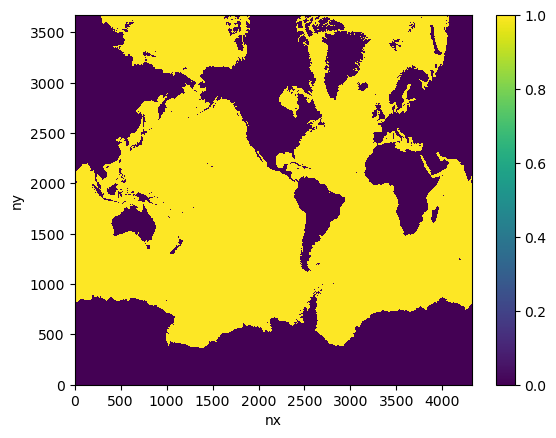

In [59]:
draft_seaice_mask = xr.where((ice_thick.thick ==0) * (draft_ocean_mask ==1), 1,0)
draft_seaice_mask.plot()

Now want to replace edge of land mask (0s) with ocean for regions in Antarctica where we might have ice so that it can treat GL properly

Do this crudely by expanding ocean if "land" cells neighbour ocean

could repeat to get a larger buffer layer

not treating periodic boundary conditions x=0/4320 well at the moment.

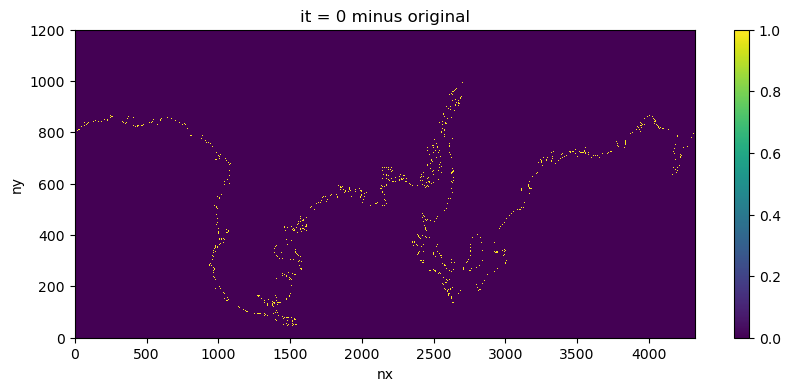

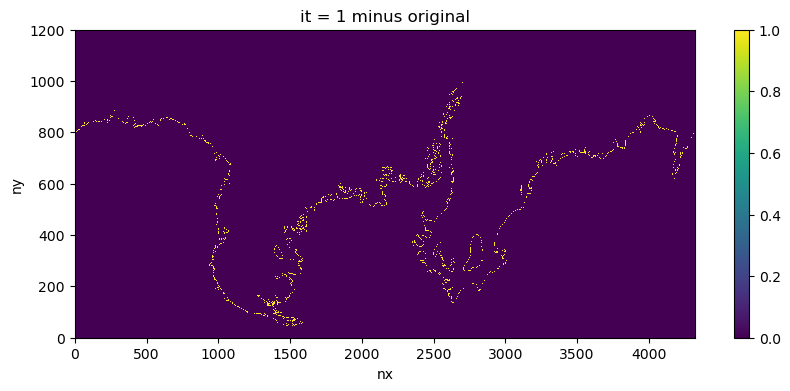

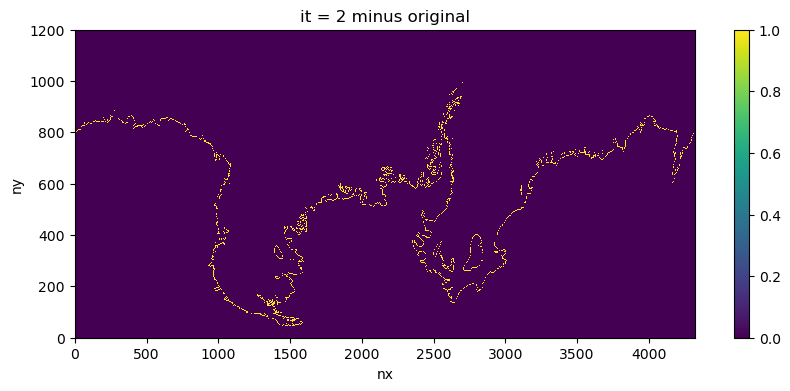

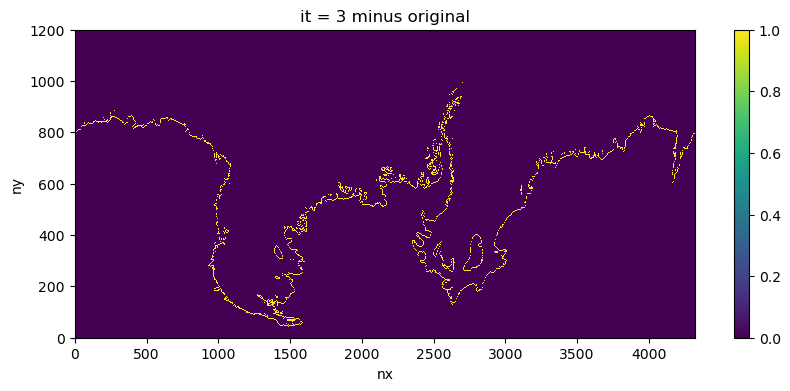

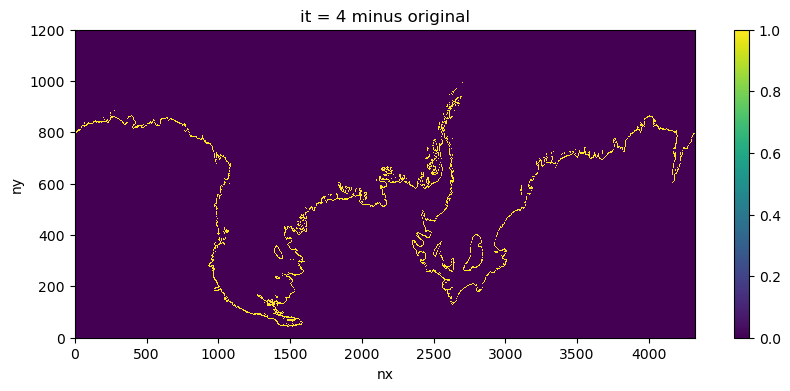

In [50]:
draft_ocean_mask_extended = draft_ocean_mask.copy()


# for j in np.arange(1,1050-1): #only antarctica
#     for i in np.arange(1,len(draft_ocean_mask.nx)-1):
#         # find ice points
#         if draft_ocean_mask_extended[j,i] ==0:
#             if ((draft_ocean_mask_extended[j-1,i] ==1) or (draft_ocean_mask_extended[j+1,i] ==1)  or \
#                 (draft_ocean_mask_extended[j,i-1] ==1) or (draft_ocean_mask_extended[j,i+1] ==1)):
#                 # i.e. if neighbouring
#                 # thenmake it ocean
#                 draft_ocean_mask_extended[i,j] = 0

## parallelise with xr.roll

for j in np.arange(5): # repeat 5 times

    rolling = draft_ocean_mask_extended.roll(ny = 1) + draft_ocean_mask_extended.roll(ny = -1) + draft_ocean_mask_extended.roll(nx = -1) + draft_ocean_mask_extended.roll(nx = 1)
    # work out which points neighbour ocean (postitive definite)
    # then turn into extra ocean if point satisfties above
    extra_ocean = 1+draft_ocean_mask_extended.where(draft_ocean_mask_extended == 0).where(rolling > 0).where(rolling.ny < 1050).where(rolling.ny > 6)
    # add to mask
    draft_ocean_mask_extended = extra_ocean.fillna(0)+draft_ocean_mask_extended
    fig = plt.figure(figsize = (10,4))
    (draft_ocean_mask_extended-draft_ocean_mask).plot()
    plt.ylim(0,1200)
    plt.title('it = '+str(j)+' minus original')
    plt.show()
    # plot and iterate


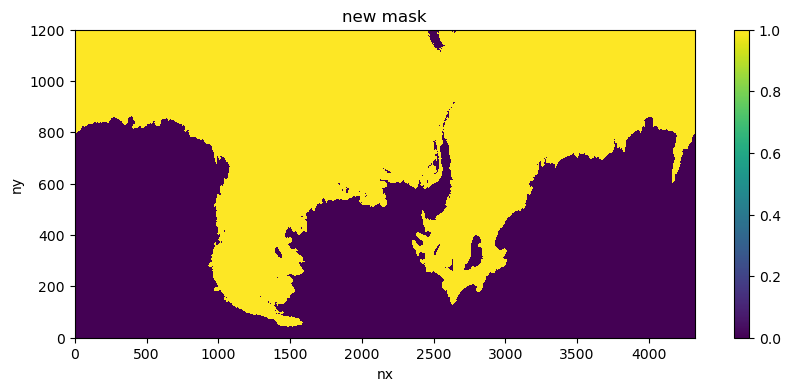

In [51]:
fig = plt.figure(figsize = (10,4))
(draft_ocean_mask_extended).plot()
plt.ylim(0,1200)
plt.title('new mask')
plt.show()

What about known areas of "ice free land" - are they treated properly here?